In [13]:
# 필수 데이터 분석 및 시각화, 백테스팅 라이브러리 설치
%pip install pandas numpy plotly bt quantstats requests python-dotenv nbformat openai

Note: you may need to restart the kernel to use updated packages.


# ETF 분석 + LLM 리포트 자동 생성 실습

이 노트북의 목표:

1. KIS API + data_manager를 이용해 ETF NAV 시계열을 불러온다.
2. 수익률·위험 지표(CAGR, 변동성, MDD, Sharpe, Sortino 등)를 계산하는 헬퍼 함수를 만든다.
3. bt 라이브러리로 Buy & Hold 백테스트를 실행한다.
4. 위에서 계산한 지표들을 LLM(OpenAI)에 넘겨, 
   "ETF 분석 리포트"를 자동 생성하는 end-to-end 파이프라인을 완성한다.

## Step 1. KIS 환경 설정 & 공통 유틸

In [14]:
from pathlib import Path
from datetime import datetime
from typing import Dict, Any, Optional

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import bt
import quantstats as qs
import requests

from kis.auth import (
    ensure_kis_token,
    KIS_URL_BASE,
    get_api_headers,
)
from kis.utils import to_float
from kis.etf_name import get_etf_name
from data_manager import load_or_download_nav  # 이전 강의에서 만든 모듈

# 강의에서 계속 사용할 ETF 코드들
DEFAULT_ETF_CODES = ["069500", "153130", "329750"]  # KODEX 200, 단기채, TIGER 미국나스닥100 등 가정

for code in DEFAULT_ETF_CODES:
    print(code, "→", get_etf_name(code))

✅ ETF 이름(MST): 069500 → KODEX 200
069500 → KODEX 200
✅ ETF 이름(MST): 153130 → KODEX 단기채권
153130 → KODEX 단기채권
✅ ETF 이름(MST): 329750 → TIGER 미국달러단기채권액티브
329750 → TIGER 미국달러단기채권액티브


## Step 2. ETF NAV 시계열 로딩 + 기초 시각화 (pyplot)

In [15]:
# NAV 시계열 로드 (이미 있으면 CSV, 없으면 KIS API 호출 후 캐시)
nav_map: Dict[str, pd.DataFrame] = {
    "069500": load_or_download_nav("069500", start="2010-01-01"),
    "153130": load_or_download_nav("153130", start="2012-01-01"),
    "329750": load_or_download_nav("329750", start="2015-01-01"),
}

for code, df in nav_map.items():
    print(f"{code}:", df.index.min().date(), "→", df.index.max().date(), ", rows:", len(df))

[LOAD] 069500 NAV.csv: 2010-06-24 ~ 2025-11-26 (1600일)
[LOAD] 153130 NAV.csv: 2012-06-27 ~ 2025-11-26 (1400일)
[LOAD] 329750 NAV.csv: 2019-07-24 ~ 2025-11-26 (683일)
069500: 2010-06-24 → 2025-11-26 , rows: 1600
153130: 2012-06-27 → 2025-11-26 , rows: 1400
329750: 2019-07-24 → 2025-11-26 , rows: 683


### 2-1. PyPlot으로 단일 ETF 차트 그리기

/var/folders/n8/6b4ymhzn5zj1ds3qf4psgcpc0000gn/T/ipykernel_21790/630424631.py:7: UserWarning:

Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) Arial.

/var/folders/n8/6b4ymhzn5zj1ds3qf4psgcpc0000gn/T/ipykernel_21790/630424631.py:7: UserWarning:

Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) Arial.

/var/folders/n8/6b4ymhzn5zj1ds3qf4psgcpc0000gn/T/ipykernel_21790/630424631.py:7: UserWarning:

Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) Arial.

/var/folders/n8/6b4ymhzn5zj1ds3qf4psgcpc0000gn/T/ipykernel_21790/630424631.py:7: UserWarning:

Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) Arial.

/var/folders/n8/6b4ymhzn5zj1ds3qf4psgcpc0000gn/T/ipykernel_21790/630424631.py:7: UserWarning:

Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) Arial.

/var/folders/n8/6b4ymhzn5zj1ds3qf4psgcpc0000gn/T/ipykernel_21790/630424631.py:7: UserWarning:

Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) Arial.

/Users/ulift/workspace/py-etf

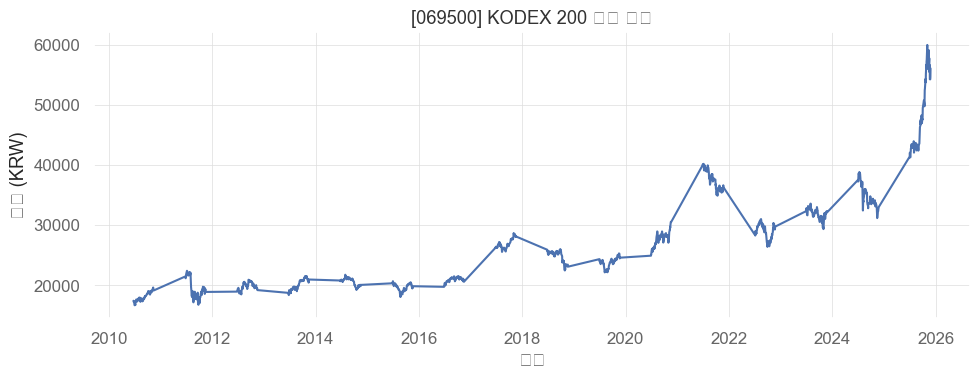

In [16]:
plt.figure(figsize=(10, 4))
plt.plot(nav_map["069500"].index, nav_map["069500"]["Close"])
plt.title("[069500] KODEX 200 종가 차트")
plt.xlabel("날짜")
plt.ylabel("종가 (KRW)")
plt.grid(True)
plt.tight_layout()
plt.show()

### 2-2. 두 ETF를 시작점=100으로 정규화해서 비교 (시각화)


In [17]:
def normalize_to_100(series: pd.Series) -> pd.Series:
    """시작일 기준 100으로 정규화"""
    return series / series.iloc[0] * 100

df1 = nav_map["069500"].copy()
df2 = nav_map["153130"].copy()

# 공통 구간 맞추기
start = max(df1.index.min(), df2.index.min())
df1 = df1[df1.index >= start]
df2 = df2[df2.index >= start]

common_index = df1.index.intersection(df2.index)
s1 = df1.loc[common_index, "Close"]
s2 = df2.loc[common_index, "Close"]

ret1 = (s1.iloc[-1] / s1.iloc[0] - 1) * 100
ret2 = (s2.iloc[-1] / s2.iloc[0] - 1) * 100

df_norm = pd.DataFrame({
    "Date": common_index,
    "KODEX 200": normalize_to_100(s1),
    "KODEX 단기채권": normalize_to_100(s2),
})

fig = px.line(
    df_norm,
    x="Date",
    y=["KODEX 200", "KODEX 단기채권"],
    title=(
        "KODEX 200 vs KODEX 단기채권 - 정규화 수익률 비교"
        + f"<br><sup>KODEX 200: {ret1:+.2f}%, 단기채권: {ret2:+.2f}%</sup>"
    ),
    labels={"value": "정규화 가격(시작=100)", "variable": "ETF"},
)
fig.update_layout(width=900, height=500)
fig.show()

## Step 3. 수익률·위험 지표 계산 헬퍼 (quantstats 기반)

- 입력: NAV 시계열 (DataFrame, Close 컬럼 포함), (선택) 벤치마크 시계열
- 출력: dict 형태의 지표 모음
  - CAGR, 연환산 변동성, Max Drawdown, Sharpe, Sortino, (선택) Alpha, Beta 등

In [18]:
def calc_alpha_beta(
    asset_rets: pd.Series,
    bench_rets: pd.Series,
    rf: float = 0.025,   # 연간 무위험 금리 (예: 2.5%)
):
    """
    단순 CAPM 기반 alpha, beta 계산
    - asset_rets, bench_rets: 일간 수익률(퍼센트가 아니라 소수, ex: 0.01 = 1%)
    - rf: 연간 무위험 금리 (ex: 0.025 = 2.5%)
    반환: (alpha_annual, beta)
    """
    # 인덱스 맞추고 공통 구간만 사용
    df = pd.concat(
        [asset_rets.rename("asset"), bench_rets.rename("bench")],
        axis=1
    ).dropna()

    if df.empty:
        return None, None

    ar = df["asset"]
    br = df["bench"]

    # 1) beta = Cov(asset, bench) / Var(bench)
    cov = np.cov(ar, br)[0, 1]
    var_b = np.var(br)
    if var_b == 0:
        return None, None
    beta = cov / var_b

    # 2) alpha: 초과수익 기준 CAPM
    #    E[R_a] - r_f - beta * (E[R_b] - r_f)
    rf_daily = rf / 252
    excess_a = ar - rf_daily
    excess_b = br - rf_daily

    alpha_daily = excess_a.mean() - beta * excess_b.mean()
    alpha_annual = alpha_daily * 252   # 단순 252배 annualize

    return alpha_annual, beta

In [19]:
def compute_risk_metrics(
    nav_df: pd.DataFrame,
    rf: float = 0.025,
    benchmark_df: Optional[pd.DataFrame] = None,
) -> Dict[str, Any]:
    """
    nav_df: 'Close' 컬럼을 가진 DataFrame, index = Date
    benchmark_df: 벤치마크 ETF NAV (동일 형식, 선택)
    """
    prices = nav_df["Close"].dropna()
    rets = prices.pct_change().dropna()

    if rets.empty:
        return {
            "start": None,
            "end": None,
            "cagr_pct": None,
            "vol_annual_pct": None,
            "mdd_pct": None,
            "sharpe": None,
            "sortino": None,
            "alpha_pct": None,
            "beta": None,
        }

    start = prices.index[0].strftime("%Y-%m-%d")
    end = prices.index[-1].strftime("%Y-%m-%d")

    # quantstats 기본 지표들
    cagr = qs.stats.cagr(rets) * 100
    vol_annual = rets.std() * np.sqrt(252) * 100
    mdd = qs.stats.max_drawdown(rets) * 100
    sharpe = qs.stats.sharpe(rets, rf=rf)
    sortino = qs.stats.sortino(rets, rf=rf)

    alpha_pct = None
    beta = None

    if benchmark_df is not None:
        bench_prices = benchmark_df["Close"].reindex(prices.index).dropna()

        aligned = pd.DataFrame({
            "asset": prices,
            "bench": bench_prices,
        }).dropna()

        asset_rets = aligned["asset"].pct_change().dropna()
        bench_rets = aligned["bench"].pct_change().dropna()

        if not asset_rets.empty and not bench_rets.empty:
            alpha_annual, beta_val = calc_alpha_beta(asset_rets, bench_rets, rf=rf)
            if beta_val is not None:
                beta = beta_val
                alpha_pct = alpha_annual * 100

    return {
        "start": start,
        "end": end,
        "cagr_pct": round(cagr, 2),
        "vol_annual_pct": round(vol_annual, 2),
        "mdd_pct": round(mdd, 2),
        "sharpe": round(float(sharpe), 3) if sharpe is not None else None,
        "sortino": round(float(sortino), 3) if sortino is not None else None,
        "alpha_pct": round(alpha_pct, 2) if alpha_pct is not None else None,
        "beta": round(float(beta), 3) if beta is not None else None,
    }

# 예시: 329750을 069500(KOSPI200)을 벤치마크로 두고 지표 계산
metrics_329750 = compute_risk_metrics(nav_map["329750"], rf=0.025, benchmark_df=nav_map["069500"])
metrics_329750

{'start': '2019-07-24',
 'end': '2025-11-26',
 'cagr_pct': np.float64(14.21),
 'vol_annual_pct': np.float64(11.33),
 'mdd_pct': np.float64(-10.07),
 'sharpe': 1.011,
 'sortino': 1.896,
 'alpha_pct': np.float64(13.44),
 'beta': -0.058}

## Step 4. bt 라이브러리로 Buy & Hold 백테스트 실행

- 각 ETF를 "사서 보유" 전략으로 백테스트
- 결과(display)를 LLM에 그대로 넘겨 설명을 요청할 수 있음

In [20]:
def build_price_dataframe(etf_codes, nav_map):
    """
    etf_codes: ["069500", "153130", ...]
    nav_map: {"069500": df_069500, ...}
    → 각 ETF의 Close를 하나의 DataFrame으로 합치기
    """
    data = pd.DataFrame()
    for code in etf_codes:
        df = nav_map[code][["Close"]].rename(columns={"Close": code})
        data = pd.concat([data, df], axis=1)

    data = data.dropna(how="any")  # 공통 구간만 추려서 사용
    return data


def run_buy_hold_backtest(price_df: pd.DataFrame, rf: float = 0.025):
    """
    price_df: index = Date, columns = ETF 코드들
    → 각 컬럼별로 동일한 Buy & Hold 전략을 적용
    """
    strategy = bt.Strategy("Buy & Hold", [
        bt.algos.RunOnce(),
        bt.algos.SelectAll(),
        bt.algos.WeighEqually(),
        bt.algos.Rebalance(),
    ])

    backtests = []
    for col in price_df.columns:
        bt_obj = bt.Backtest(strategy, price_df[[col]], name=col)
        backtests.append(bt_obj)

    res = bt.run(*backtests)
    res.set_riskfree_rate(rf)
    return res


price_df = build_price_dataframe(DEFAULT_ETF_CODES, nav_map)
res = run_buy_hold_backtest(price_df, rf=0.025)

# 콘솔표 출력
res.display()

100%|██████████| 3/3 [00:00<00:00, 22.26it/s]


Stat                 069500      153130      329750
-------------------  ----------  ----------  ----------
Start                2019-07-23  2019-07-23  2019-07-23
End                  2025-11-26  2025-11-26  2025-11-26
Risk-free rate       2.50%       2.50%       2.50%

Total Return         131.45%     11.91%      43.18%
Daily Sharpe         0.98        0.86        1.01
Daily Sortino        1.95        13.53       2.16
CAGR                 14.14%      1.79%       5.82%
Max Drawdown         -33.97%     -0.13%      -10.05%
Calmar Ratio         0.42        14.23       0.58

MTD                  -3.61%      0.10%       3.10%
3m                   30.10%      0.40%       5.94%
6m                   68.94%      2.31%       8.90%
YTD                  68.94%      2.31%       8.90%
1Y                   68.94%      2.31%       8.90%
3Y (ann.)            25.39%      2.83%       9.15%
5Y (ann.)            7.90%       2.24%       9.20%
10Y (ann.)           -           -           -
Since Incep. (ann

### 4-1. bt 결과를 문자열(markdown)로 변환 (LLM에 넘기기 좋게)

In [21]:
from io import StringIO
import sys

def backtest_result_to_markdown(res: bt.backtest.Result) -> str:
    """
    bt 결과(res.display())를 텍스트로 캡처해서
    그대로 Markdown code block으로 감싼다.
    """
    old_stdout = sys.stdout
    sys.stdout = mystdout = StringIO()
    try:
        res.display()
    finally:
        sys.stdout = old_stdout

    full_txt = mystdout.getvalue()
    md = "```text\n" + full_txt.strip() + "\n```"
    return md


bt_markdown_all = backtest_result_to_markdown(res)
print(bt_markdown_all[:500], "...")

```text
Stat                 069500      153130      329750
-------------------  ----------  ----------  ----------
Start                2019-07-23  2019-07-23  2019-07-23
End                  2025-11-26  2025-11-26  2025-11-26
Risk-free rate       2.50%       2.50%       2.50%

Total Return         131.45%     11.91%      43.18%
Daily Sharpe         0.98        0.86        1.01
Daily Sortino        1.95        13.53       2.16
CAGR                 14.14%      1.79%       5.82%
Max Drawdown      ...


## Step 5. 개별 ETF 스냅샷 + 지표 → LLM용 컨텍스트 만들기

- 여기서는 "헬퍼 함수"를 두 층으로 나눈다:
  1. `fetch_etf_price_snapshot` : KIS 시세 API 한 번 호출해서, 현재가·NAV·AUM 등을 가져오기
  2. `build_etf_context` : NAV 시계열 + snapshot + risk metrics + backtest 요약을 하나의 dict로 묶기

In [22]:
def fetch_etf_price_snapshot(etf_code: str) -> Dict[str, Any]:
    """
    KIS 시세 조회 API로 ETF의 현재가/NAV/AUM/괴리율 등 스냅샷을 가져오는 함수.
    (이 강의 노트북 전용으로 설계)
    """
    ensure_kis_token()

    url = f"{KIS_URL_BASE}/uapi/etfetn/v1/quotations/inquire-price"
    params = {"FID_COND_MRKT_DIV_CODE": "J", "FID_INPUT_ISCD": etf_code}
    headers = get_api_headers("FHPST02400000")

    res = requests.get(url, headers=headers, params=params, timeout=5)
    data = res.json()

    if data.get("rt_cd") != "0":
        raise RuntimeError(f"[{etf_code}] 시세 조회 실패: {data.get('msg1')}")

    o = data["output"]

    current_price       = to_float(o.get("stck_prpr"))
    volume              = to_float(o.get("acml_vol"))
    nav                 = to_float(o.get("nav"))
    nav_change          = to_float(o.get("nav_prdy_vrss"))
    nav_change_pct      = to_float(o.get("nav_prdy_ctrt"))
    listing_date_raw    = o.get("stck_lstn_date")
    aum_from_api        = to_float(o.get("etf_ntas_ttam"))
    aum_circulating_api = to_float(o.get("etf_crcl_ntas_ttam"))
    circulating_shares  = to_float(o.get("etf_crcl_stcn"))
    tracking_error_api  = to_float(o.get("trc_errt"))

    # 상장일/경과 기간
    listing_date = None
    years_since = None
    days_since = None
    if listing_date_raw:
        listing_date = datetime.strptime(listing_date_raw, "%Y%m%d")
        days_since = (datetime.now() - listing_date).days
        years_since = days_since / 365.25

    # AUM 계산
    aum_from_calc = None
    if nav and circulating_shares:
        aum_from_calc = nav * circulating_shares

    if aum_from_calc:
        aum_total = aum_from_calc
    elif aum_from_api:
        aum_total = aum_from_api * 100_000_000  # 억 단위 보정
    else:
        aum_total = None

    aum_billion = aum_total / 100_000_000 if aum_total else None
    aum_trillion = aum_billion / 10_000 if aum_billion else None

    # 괴리율
    premium = None
    if current_price and nav and nav > 0:
        premium = (current_price - nav) / nav * 100

    # 오늘 거래대금
    turnover_billion = None
    if current_price and volume:
        turnover_billion = current_price * volume / 100_000_000

    snapshot = {
        "etf_code": etf_code,
        "etf_name": get_etf_name(etf_code),
        "listing_date": listing_date.strftime("%Y-%m-%d") if listing_date else None,
        "days_since_listing": days_since,
        "years_since_listing": round(years_since, 2) if years_since else None,
        "current_price": current_price,
        "volume": volume,
        "nav": nav,
        "nav_change": nav_change,
        "nav_change_pct": nav_change_pct,
        "premium_pct": premium,
        "turnover_billion": turnover_billion,
        "aum_total": aum_total,
        "aum_billion": aum_billion,
        "aum_trillion": aum_trillion,
        "tracking_error_api": tracking_error_api,
    }
    return snapshot


def build_etf_context(
    etf_code: str,
    nav_df: pd.DataFrame,
    risk_free_rate: float,
    benchmark_df: Optional[pd.DataFrame],
    bt_markdown: str,
) -> Dict[str, Any]:
    """
    입력:
      - etf_code: "069500" 등
      - nav_df: NAV 시계열 (Close 컬럼 포함)
      - risk_free_rate: 무위험 이자율
      - benchmark_df: 벤치마크 NAV (없으면 None)
      - bt_markdown: bt.display()를 변환한 문자열

    출력:
      - LLM에 그대로 넘겨도 되는 '컨텍스트 dict'
    """
    snapshot = fetch_etf_price_snapshot(etf_code)
    metrics = compute_risk_metrics(nav_df, rf=risk_free_rate, benchmark_df=benchmark_df)

    context = {
        "as_of": datetime.now().strftime("%Y-%m-%d"),
        "ticker": etf_code,
        "name": snapshot["etf_name"],
        "snapshot": snapshot,
        "risk_metrics": metrics,
        "backtest_summary": bt_markdown,
    }
    return context

# 예시: 069500 컨텍스트 생성
context_069500 = build_etf_context(
    etf_code="069500",
    nav_df=nav_map["069500"],
    risk_free_rate=0.025,
    benchmark_df=None,           # 069500 자체는 벤치마크 없이도 충분
    bt_markdown=bt_markdown_all, # 통합 bt 결과를 넘겨도 되고, 개별만 뽑아도 됨
)

print(json.dumps(context_069500, ensure_ascii=False, indent=2)[:800], "...")

✅ ETF 이름(MST): 069500 → KODEX 200
{
  "as_of": "2025-11-27",
  "ticker": "069500",
  "name": "KODEX 200",
  "snapshot": {
    "etf_code": "069500",
    "etf_name": "KODEX 200",
    "listing_date": "2002-10-14",
    "days_since_listing": 8445,
    "years_since_listing": 23.12,
    "current_price": 56475.0,
    "volume": 8441435.0,
    "nav": 56550.22,
    "nav_change": 417.24,
    "nav_change_pct": 0.74,
    "premium_pct": -0.13301451347139084,
    "turnover_billion": 4767.30041625,
    "aum_total": 10736059267000.0,
    "aum_billion": 107360.59267,
    "aum_trillion": 10.736059267,
    "tracking_error_api": 0.7
  },
  "risk_metrics": {
    "start": "2010-06-24",
    "end": "2025-11-26",
    "cagr_pct": 20.21,
    "vol_annual_pct": 29.13,
    "mdd_pct": -34.32,
    "sharpe": 0.685,
    "sortino": 1.257,
    "alpha_pct": nul ...


## Step 6. LLM 호출: ETF 분석 리포트 생성
# 
- 입력: 방금 만든 `context_069500` 같은 dict
- 출력: A4 1장 분량 ETF 분석 리포트 (Markdown)

In [23]:
SYSTEM_MESSAGE = """
당신은 전문 펀드 매니저 겸 리서치 애널리스트입니다.
ETF 투자에 대해 깊이 있는 분석과 실질적인 조언을 제공합니다.
답변은 항상 한국어로 작성하고, Markdown 형식을 활용해 체계적으로 정리하세요.
"""

DEVELOPER_MESSAGE = """
당신은 ETF 전문 리서치 애널리스트입니다.
프롬프트에 포함된 지표(CAGR, 변동성, MDD, Sharpe, Sortino, 프리미엄/디스카운트, AUM 등)를 바탕으로
입문~중급 투자자를 대상으로 ETF를 설명하고, 투자 시 유의사항과 활용 전략을 제시해 주세요.

# 출력 형식
- 답변은 반드시 한국어로 작성
- Markdown 구조(제목, 소제목, 표, 목록)를 적극 활용
- 지표 수치는 해석 중심(좋다/나쁘다/주의점)을 명확히 설명
- 과거 수익률이 미래를 보장하지 않는다는 점은 반드시 한 번 언급

# 금지사항
- 허위 정보 생성 금지
- 확인 불가능한 미래 수익률 예측 금지
"""

def build_user_prompt_from_context(ctx: Dict[str, Any]) -> str:
    """
    build_etf_context에서 만든 dict를 기반으로
    LLM에 넘길 user 프롬프트 문자열을 생성.
    """
    return f"""
한국거래소 상장 ETF [{ctx['ticker']}] {ctx['name']} 에 대해,
다음 정보를 기반으로 A4 1페이지 분량의 분석 리포트를 작성해 주세요.

[스냅샷]
{json.dumps(ctx['snapshot'], ensure_ascii=False, indent=2)}

[수익률·위험 지표]
{json.dumps(ctx['risk_metrics'], ensure_ascii=False, indent=2)}

[백테스트 요약]
{ctx['backtest_summary']}

요구사항:
- 1) 전체 요약
- 2) ETF 기본 정보 및 특징
- 3) 수익성과 위험성 해설 (위 지표들 직접 언급)
- 4) 어떤 투자자에게 적합한지, 어떤 상황에서 유용한지
- 5) 투자 시 주의할 점
"""

In [25]:
from openai import OpenAI
client = OpenAI()

def call_llm_report(user_prompt: str, model: str = "gpt-5.1"):
    response = client.responses.create(
        model=model,
        input=[
            {"role": "system", "content": SYSTEM_MESSAGE},
            {"role": "developer", "content": DEVELOPER_MESSAGE},
            {"role": "user", "content": user_prompt},
        ],
        tools=[{"type": "web_search"}],
        reasoning={"effort": "medium"}
    )
    return response.output_text

# 실제 호출 예시 (API 키 필요)
USER_PROMPT_069500 = build_user_prompt_from_context(context_069500)
report_069500 = call_llm_report(USER_PROMPT_069500)

print(report_069500[:1500], "...")

# 저장
REPORT_DIR = Path("reports")
REPORT_DIR.mkdir(parents=True, exist_ok=True)
out_path = REPORT_DIR / f"report_{context_069500['ticker']}_{context_069500['as_of']}.md"
out_path.write_text(report_069500, encoding="utf-8")
print("보고서 저장 완료:", out_path)

# KODEX 200 (069500) 분석 리포트  

## 1) 전체 요약  

- **KODEX 200(069500)**은 KOSPI200지수를 추종하는 국내 대표 **코어 주식 ETF**로, 상장 후 20년 이상 운용된 **국내 최대급 규모(약 10.7조원 AUM)**, **높은 유동성**을 가진 상품입니다.  
- 2010년 6월~2025년 11월 구간 기준 **연복리 수익률(CAGR) 20.21%**, **연 변동성 29.13%**, **MDD -34.32%**로, **전형적인 주식형(대형주 지수) 위험·수익 프로파일**을 보여줍니다.  
- 2019년 7월 이후 백테스트에서도 **연 14.14% CAGR**, **샤프지수 0.98**, **연 변동성 29.15%**, **MDD -33.97%**로, 장기 보유 시 우수한 성과를 기록했지만, **단기 변동과 큰 낙폭을 감수해야 하는 상품**임이 분명합니다.  
- **국내 주식 비중을 코어로 가져가고 싶은 장기 투자자**, **개별 종목 대신 지수로 분산투자하려는 투자자**, **연금·ISA 등 장기 계좌의 주식 비중 채우기** 용도로 적합합니다.  
- 다만 **한국 대형주·단일국가·주식형 리스크**에 집중된 상품이므로, **포트폴리오 전체 관점에서 채권/해외자산과의 분산**, **낙폭(MDD) 감내 가능 수준 확인**이 필수입니다.  
- ※ **과거 수익률은 미래 수익률을 보장하지 않으며**, 본 리포트는 특정 종목 매수를 권유하는 것이 아닙니다.  

---

## 2) ETF 기본 정보 및 특징  

### 2-1. 기본 스냅샷  

| 구분 | 내용 |
|------|------|
| 종목명 | KODEX 200 |
| 티커 | 069500 |
| 상장일 | 2002-10-14 |
| 상장 이후 경과기간 | 약 23.1년 |
| 기준가(NAV) | 56,550.22원 |
| 시장가격 | 56,475원 |
| 프리미엄/디스카운트 | 약 **-0.13% (소폭 디스카운트)** |
| 일 거래량 